# Analysing Superconductivity Measurements
Team: Ryan E, Ryan S, Charlie, Lin

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [17]:
filename = 'data/Measurement_1_0.50_Field_0_Angle.csv'

df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
df

C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3762058988.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)


,current_A,voltage_uV,time_s
0,0.002252,-0.772845,0.000
1,0.002388,-0.769311,0.046
2,0.002741,-0.761247,0.092
3,0.002574,-0.745235,0.139
4,0.002520,-0.741827,0.185
...,...,...,...
874,37.112894,46.353972,56.388
875,37.143997,46.651341,56.434
876,37.174254,46.942966,56.480
877,37.205899,47.221457,56.526


Extracting metadata by reading the file - temperature, angle and magnetic field.

In [18]:
# Step 1: Open the file and read lines manually
f = open(filename)
text = f.readlines()

# Step 2: Extract metadata, ignoring blank lines
def extract_value(lines, key):
    """Helper function to extract the value for a given key."""
    for line in lines:
        if key in line:
            return float(line.split('\t')[1].strip())  # Extract the value after tab

temperature = extract_value(text, "Temperature (K)")
angle = extract_value(text, "Angle (deg.)")
field = extract_value(text, "field / T")
print(f'T={temperature}, Angle={angle}, Field={field}')

T=77.0, Angle=0.0, Field=0.5


Quick Plot of Voltage (uV) vs Current (A): 

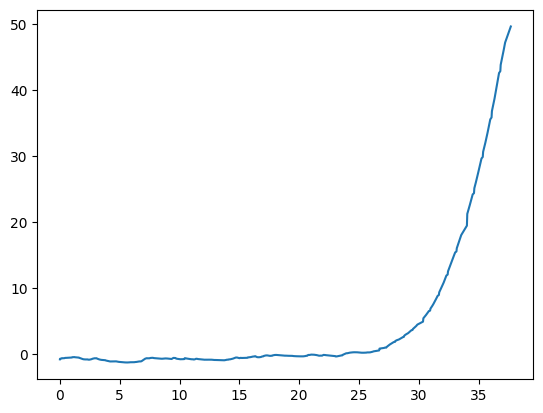

In [19]:
plt.plot(df['current_A'],df['voltage_uV'])

To find the critical current $I_C$, we read off the graph where we have an electric field E=100 uV/m. The distance between our voltage points on the sample is 0.8 cm. Therefore the voltage where this occurs is E*m = 100 uV/m * 0.008 m = 0.8 uV.

After speaking to demonstrator, we chose an electric field of 2000 uV/m instead which corresponds to a voltage V = 20 uV.

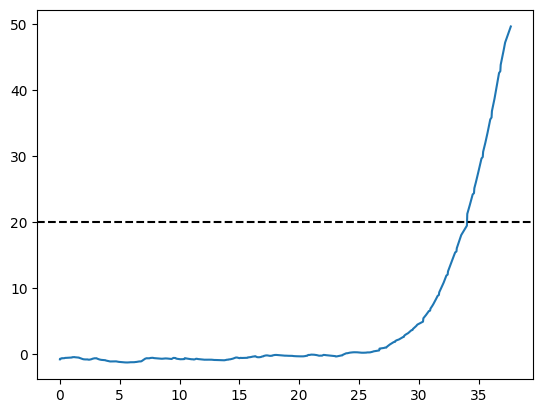

In [22]:
fig, ax = plt.subplots()
ax.plot(df['current_A'],df['voltage_uV'])
ax.axhline(20, c="black", ls="--")

In [29]:
(df['voltage_uV'] - 20).abs().idxmin()

793

In [30]:
I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

Now we have the code, we will now iterate through all the data files.

C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3047488014.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3047488014.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3047488014.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipy

[]

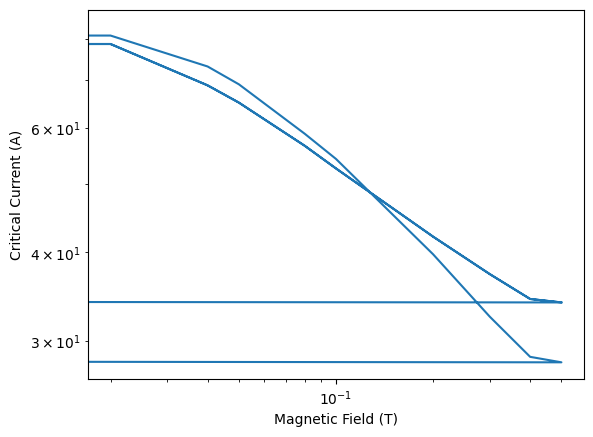

In [57]:
# Iterate through files in specified directory #
columns=['angle','field','I_c']
df_Ic_0 = pd.DataFrame(columns=columns)

directory = 'data/'
rows = []
for filename in os.listdir(directory):
    try:
        file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
        df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)

    except:
        print(f"Error: {file_string} is probably corrupted or you have incorrectly entered directory.")


    # Extract metadata
    f = open(file_string)
    text = f.readlines()
    def extract_value(lines, key):
        """Helper function to extract the value for a given key."""
        for line in lines:
            if key in line:
                return float(line.split('\t')[1].strip())  # Extract the value after tab
    temperature = extract_value(text, "Temperature (K)")
    angle = extract_value(text, "Angle (deg.)")
    field = extract_value(text, "field / T")
    I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

    row = [angle,field,I_c]

    rows.append(row)

df_Ic = pd.concat([df_Ic, pd.DataFrame(rows, columns=columns)], ignore_index=True)
# df_Ic = df.sort_values(by='field').reset_index(drop=True)

fig, ax = plt.subplots()
ax.plot(df_Ic['field'], df_Ic['I_c'])
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
plt.loglog()
plt.plot()

In [58]:
# Iterate through files in specified directory #
columns=['angle','field','I_c']
df_Ic_45 = pd.DataFrame(columns=columns)

directory = 'data45/'
rows = []
for filename in os.listdir(directory):
    try:
        file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
        df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)

    except:
        print(f"Error: {file_string} is probably corrupted or you have incorrectly entered directory.")


    # Extract metadata
    f = open(file_string)
    text = f.readlines()
    def extract_value(lines, key):
        """Helper function to extract the value for a given key."""
        for line in lines:
            if key in line:
                return float(line.split('\t')[1].strip())  # Extract the value after tab
    temperature = extract_value(text, "Temperature (K)")
    angle = extract_value(text, "Angle (deg.)")
    field = extract_value(text, "field / T")
    I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

    row = [angle,field,I_c]

    rows.append(row)

df_Ic_45 = pd.concat([df_Ic_45, pd.DataFrame(rows, columns=columns)], ignore_index=True)
# print(df_Ic_45)


C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3784021474.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3784021474.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipykernel_11604\3784021474.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], delim_whitespace=True)
C:\Users\ryan_\AppData\Local\Temp\ipy

[]

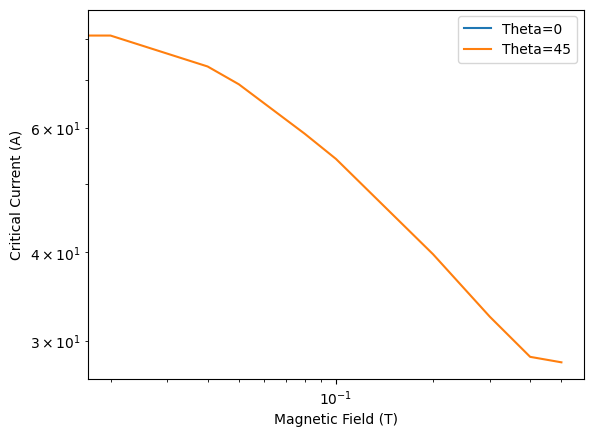

In [59]:

fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta=0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta=45")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
plt.legend()
plt.loglog()
plt.plot()